In this notebook, i create a convolutional neural network and test it.

Dataset division:
- Train set 70% of dataset.
- Validaiton set 15% of dataset, used for early_stop.
- Test set 15% of dataset, used for test the model.

All notebook is runned with V100

In [6]:
import numpy as np
import pandas as pd

import time
import os

import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import balanced_accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
images_path = '/content/drive/MyDrive/TESI/Spectogram_images/all_faults_0_load_images_180x180'

learning_path = '/content/drive/MyDrive/TESI/keras_file'

csv_path = '/content/drive/MyDrive/TESI/Csv_file/all_faults_0_load.csv'

# Data analysis of dataset

In [ ]:
# Count Images

# Get a name of fault
df = pd.read_csv(csv_path)
faults = df['fault'].unique()
#print(faults)

# Count the images
count_dict = {}
count = 0

for fault in faults:
  count_dict[fault] = 0

for root, directories, files in os.walk(images_path):
  for file in files:
    for key in count_dict.keys():
      if key in file:
        count_dict[key] = count_dict[key] +1
        count = count+1

print(count_dict)
print()
print('Total images: ', count)

if count !=10820:
  print('The expected value not satisfied')

{'IR007_0': 949, 'IR014_0': 246, 'IR021_0': 951, 'B007_0': 953, 'OR007-6_0': 948, 'OR007-3_0': 483, 'OR007-12_0': 504, 'B014_0': 970, 'OR014-6_0': 954, 'B021_0': 949, 'OR021-6_0': 959, 'OR021-3_0': 499, 'OR021-12_0': 506, 'Normal_0': 949}

Total images:  10820


In [ ]:
# Check a shape of a random image

filename_ex = os.path.join(images_path, 'Normal_0','Normal_0_0.jpeg')

# Load the saved image
image_ex = plt.imread(filename_ex)

# Print the pixel dimensions of the saved image
print(image_ex.shape)

(180, 180, 3)


# Create dataset

In [8]:
image_size = (180, 180)
batch_size = 32

train_ds, val_plus_test_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    labels="inferred",
    label_mode='categorical',
    validation_split=0.3,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 10820 files belonging to 14 classes.
Using 7574 files for training.
Using 3246 files for validation.


Using 32 batch size, it going to use 11.1 Gb of RAM GPU (V100) during training

In [ ]:
# Divide validation_plus_test dataset into 2 separate dataset.
# Divided randomly

part_size = (len(val_plus_test_ds) // 2)

#shuffled_ds = val_plus_test_ds.shuffle(reshuffle_each_iteration=False,buffer_size=32)
val_ds = val_plus_test_ds.take(part_size)
test_ds = val_plus_test_ds.skip(part_size).take(-1)

print(f'All {len(val_plus_test_ds)} banches are divided into {len(val_ds)} for validation and {len(test_ds)} for testing\n')

if len(val_plus_test_ds) != (len(val_ds) + len(test_ds)):
  print('Check the rest of division')
else:
  print('Divided without rest')

All 102 banches are divided into 51 for validation and 51 for testing

Divided without rest


In [ ]:
3246/32

101.4375

In [ ]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Create a model

Using architecture of Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.
-> Small version of the Xception network

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=14)

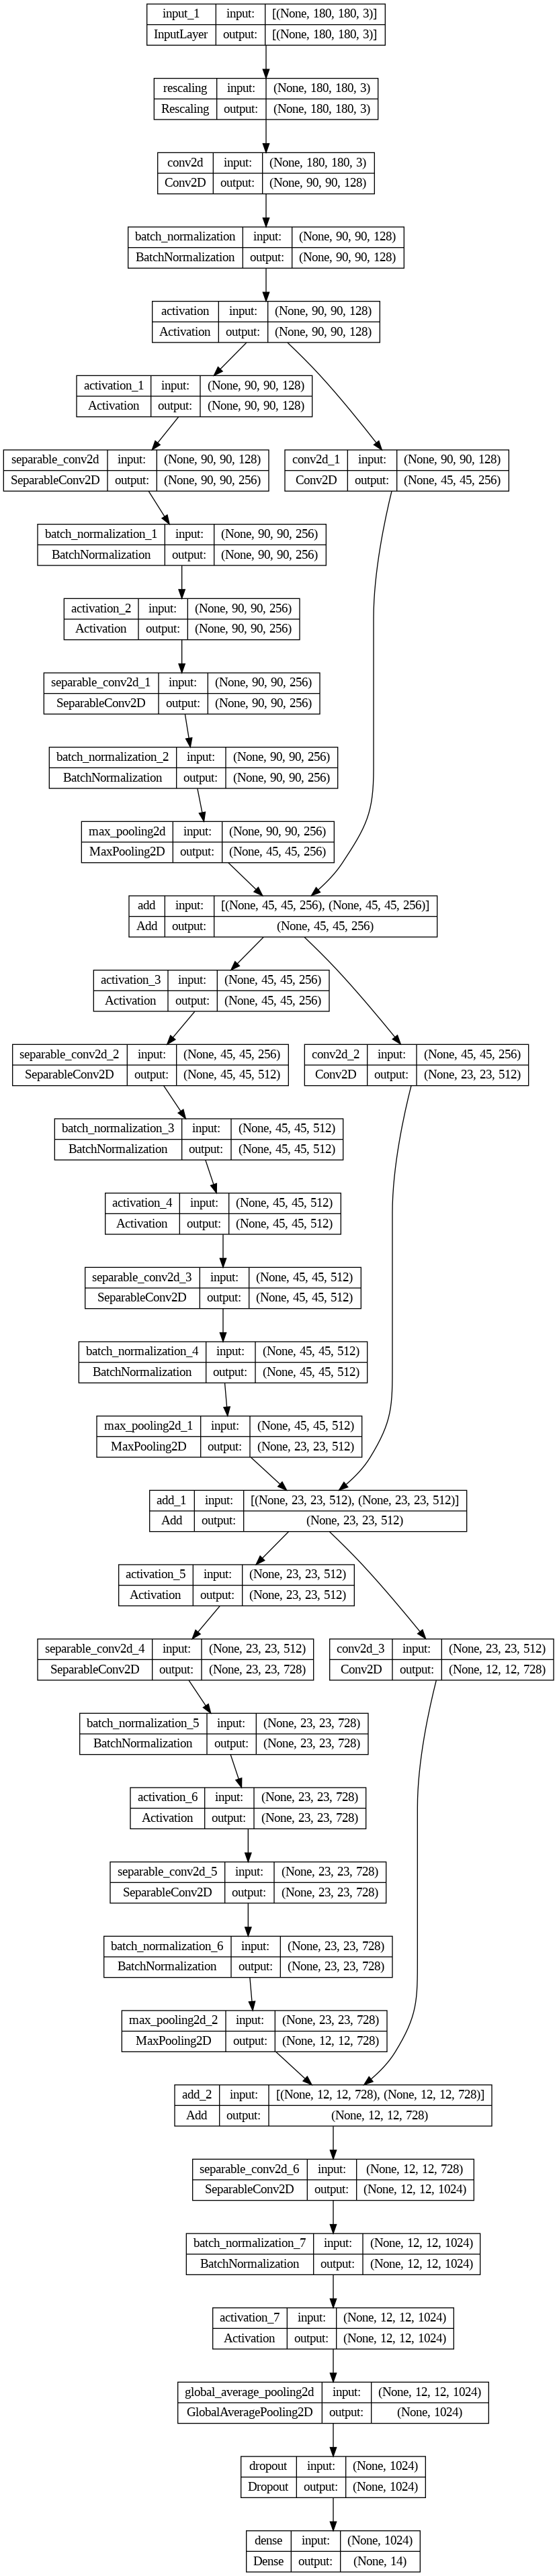

In [10]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 180, 180, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 90, 90, 128)          3584      ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 90, 90, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                               

# Fit model on training data

In [ ]:
start_time = time.time()
# Create a time stamp for save info

timestr = time.strftime("%Y%m%d-%H%M%S")
timestr = str(timestr)
name_resume = timestr + '_' + "model_4_best_epoch/cp-{epoch:04d}.ckpt"
filepath_save_model = os.path.join(learning_path, name_resume)

# Model fit param

epochs = 100

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)   # Save best model

check_point = keras.callbacks.ModelCheckpoint(filepath= filepath_save_model, monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stop, check_point],
    validation_data=val_ds,
)

# Print training duration
end_time = time.time()
execution_time = (end_time - start_time)//60
print(f"Execution time: {execution_time} minutes")

Epoch 1/100
237/237 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9296
Epoch 1: val_loss improved from inf to 4.13067, saving model to /content/drive/MyDrive/TESI/keras_file/20231011-162825_model_4_best_epoch/cp-0001.ckpt
237/237 [==============================] - 945s 4s/step - loss: 0.2458 - accuracy: 0.9296 - val_loss: 4.1307 - val_accuracy: 0.0331
Epoch 2/100
237/237 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9941
Epoch 2: val_loss did not improve from 4.13067
237/237 [==============================] - 27s 112ms/step - loss: 0.0258 - accuracy: 0.9941 - val_loss: 9.1843 - val_accuracy: 0.0331
Epoch 3/100
237/237 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9943
Epoch 3: val_loss improved from 4.13067 to 0.01762, saving model to /content/drive/MyDrive/TESI/keras_file/20231011-162825_model_4_best_epoch/cp-0003.ckpt
237/237 [==============================] - 31s 130ms/step - loss: 0.0238 - accuracy: 0.994

In [ ]:
# Save last epoch of model

name_resume = timestr + '_' + "model_4_last_epoch.keras"

model.save(os.path.join(learning_path,name_resume))

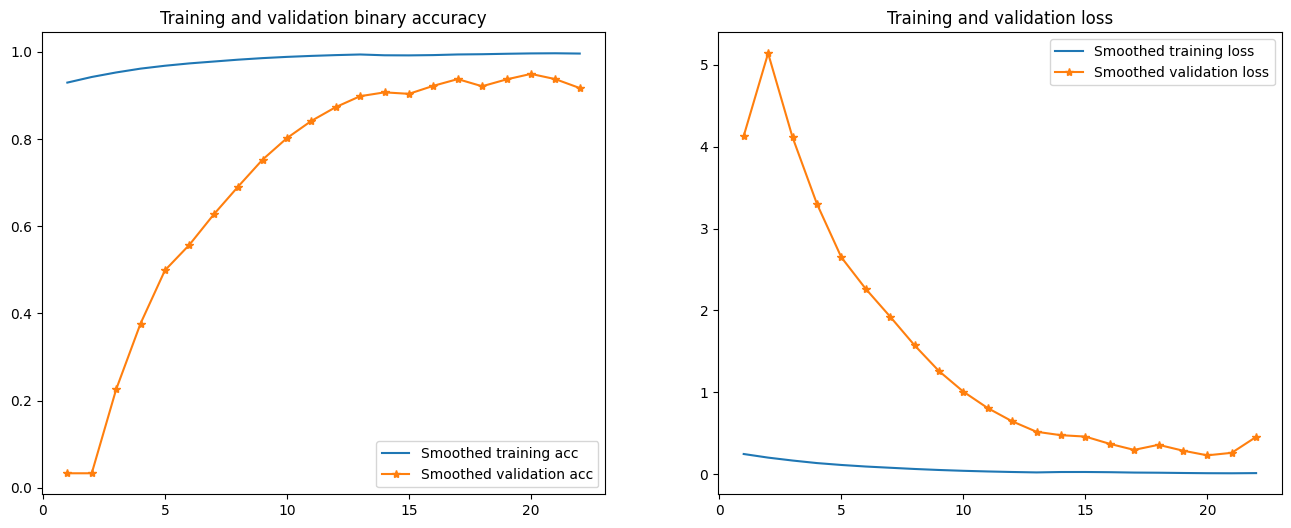

In [ ]:
# Graph evolution of model  -> smoothed

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

fig,(ax2,ax1) = plt.subplots(1,2,figsize=(16,6))
ax2.plot(epochs,smooth_curve(acc), '-', label='Smoothed training acc')
ax2.plot(epochs,smooth_curve(val_acc), '-*', label='Smoothed validation acc')
ax2.set_title('Training and validation binary accuracy')
ax2.legend()

ax1.plot(epochs,smooth_curve(loss), '-', label='Smoothed training loss')
ax1.plot(epochs,smooth_curve(val_loss), '-*', label='Smoothed validation loss')
ax1.set_title('Training and validation loss')
ax1.legend();

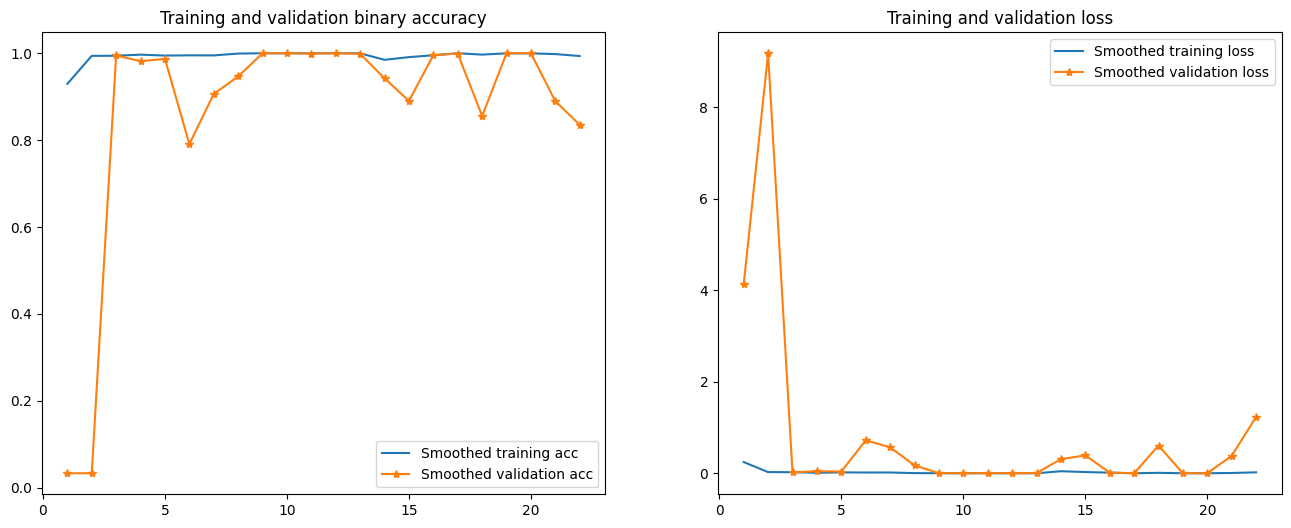

In [ ]:
# Graph evolution of model --> unsmothed

fig,(ax2,ax1) = plt.subplots(1,2,figsize=(16,6))
ax2.plot(epochs,acc, '-', label='Smoothed training acc')
ax2.plot(epochs,val_acc, '-*', label='Smoothed validation acc')
ax2.set_title('Training and validation binary accuracy')
ax2.legend()

ax1.plot(epochs,loss, '-', label='Smoothed training loss')
ax1.plot(epochs,val_loss, '-*', label='Smoothed validation loss')
ax1.set_title('Training and validation loss')
ax1.legend();

# Evaluate model with test dataset

In [ ]:
predict = model.predict(test_ds)

51/51 [==============================] - 195s 4s/step


In [ ]:
# Extract image label of validation dataset

test_ds_unbatch = test_ds.unbatch()
#images = list(test_ds_unbatch.map(lambda x, y: x))
labels = list(test_ds_unbatch.map(lambda x, y: y))

# Extract the NumPy arrays from the TensorFlow tensors.
numpy_arrays = []

for tensor in labels:
  numpy_array = tensor.numpy()
  numpy_arrays.append(numpy_array)

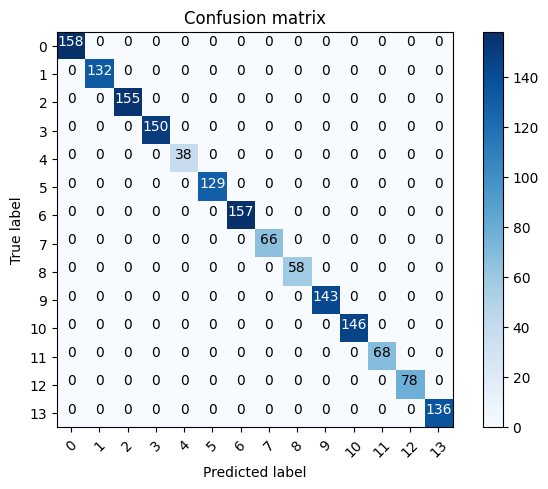

In [ ]:
# Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = predict
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(numpy_arrays ,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(14))

In [ ]:
accuracy = sklearn.metrics.balanced_accuracy_score(Y_true, Y_pred_classes)
print('----------------------------------------')
print('Accuracy balanced score: ', accuracy)
print('----------------------------------------')

----------------------------------------
Accuracy balanced score:  1.0
----------------------------------------
